In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys
sys.path.append("common/")  # это позволяет делать import из файла в параллельной папке common
from PRIM_structs import *
from PRIM_graphics import *
sys.path.append("trajectory-generation/")
from trajectory_optimization import optimization_Newton

# устанавливаем, чтобы графики рисовались прямо в окне jupyter notebook
%matplotlib inline

# Примеры генерации коротких траекторий (онлайн-визуализация)

Здесь представим три небольших примера генерации примитива (итеративным методом Ньютона) предлагаемым методом. Для удобства примитив перерисовывается в процессе генерации.

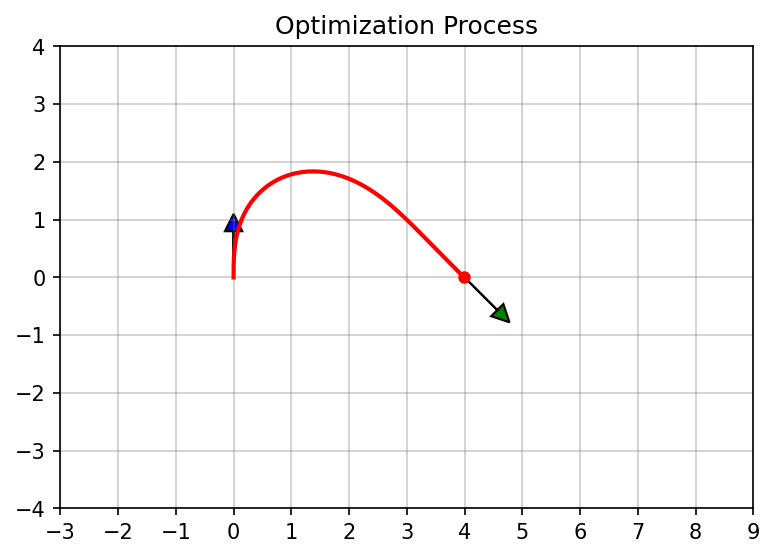

In [2]:
start = State(0, 0, np.pi/2)    # состояние, откуда выходит траектория
target = State(4, 0, -np.pi/4)  # состояние, куда должна прийти
steps, traj = optimization_Newton(start, target, redraw_trajectory=create_live_visualizer(start, target))

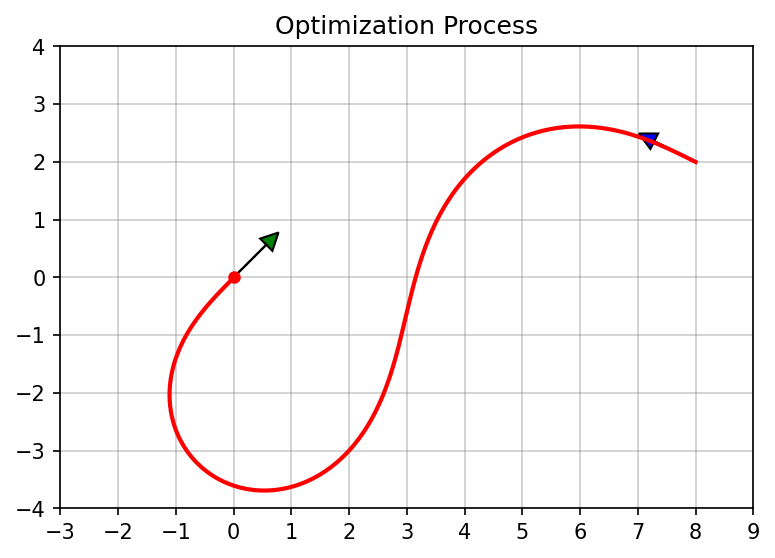

Saving GIF... Total frames: 55, Used: 48
GIF saved to optimization.gif


In [4]:
target = State(0, 0, np.deg2rad(2 / 16 * 360))
start = State(x=8.0, y=2.0, theta=np.arctan(2) + 3 * np.pi/2 - np.pi)
update, save_gif = create_live_visualizer(start, target, frequency=4, make_gif=True)  # Дополнительно сохраним gif для README
steps, traj = optimization_Newton(start, target, redraw_trajectory=update)
# save_gif(drop_last=7)

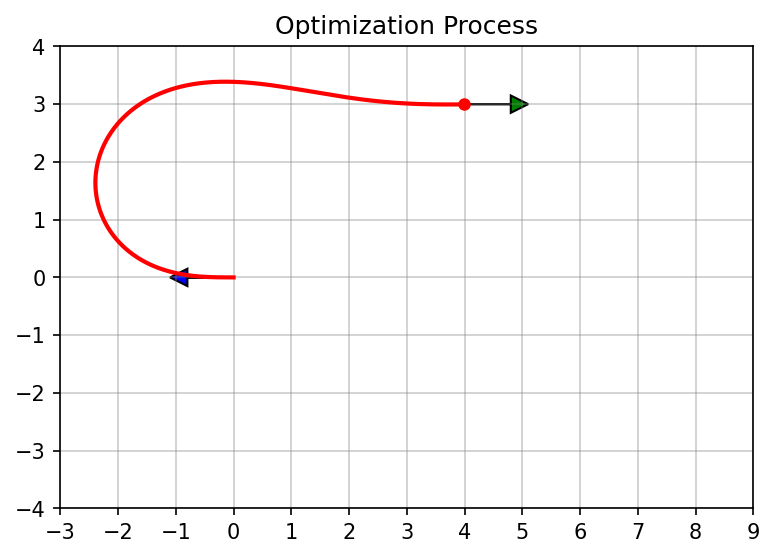

In [4]:
start = State(0, 0, np.pi)
target = State(4, 3, 0)
steps, traj = optimization_Newton(start, target, redraw_trajectory=create_live_visualizer(start, target))

# Ещё примеры возможных траекторий

Здесь сгенерируем примитивы в том числе довольно сложной формы, чтобы показать мощь и возможности предлагаемого метода. Первые 4 включены в статью в качестве иллюстрации.

In [5]:
# --- НАСТРОЙКИ ОТОБРАЖЕНИЯ ---
FIXED_X_LIM = (-1, 10)  # Размер отображаемого окна графика (по координатным осям)
FIXED_Y_LIM = (-1, 6)
GRID_STEP = 1.0         # Шаг координатной сетки (ставим риску на координатную ось каждые GRID_STEP)

In [6]:
# --- Функция рисует траектории из заданного списка сценариев (пар старт-финиш) попарно ---
def show_trajectories_pairs(scenarios):
    for i in range(0, len(scenarios), 2):  # проходим по списку с шагом 2 (берем пары)
        pair = scenarios[i : i+2]          # очередная пара
        captions = ["(a)", "(b)"]          # список подписей для текущей пары
        
        # Создаем фигуру с 2 колонками (в 1 ряд). Размеры: figsize=(12, 5) -> ширина 12 (по 6 на график), высота 5.
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
        if len(pair) == 1: 
            axes = [axes]  # если вдруг остался 1 элемент (изначально их нечетное кол-во), axes может не быть списком
        
        for j, (start, target) in enumerate(pair):
            ax = axes[j]  # текущий подграфик
            
            steps, traj = optimization_Newton(start, target)  # генерируем и рисуем траекторию
            show_trajectory(traj, ax=ax)
            
            # ФИКСАЦИЯ РАЗМЕРОВ И СЕТКИ
            ax.set_aspect('equal')    # пропорции 1:1
            ax.set_xlim(FIXED_X_LIM)  # настройки видимого окна осей координат
            ax.set_ylim(FIXED_Y_LIM)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(GRID_STEP))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(GRID_STEP))
            ax.grid(visible=True, which='both')
            # ax.set_title(f"Trajectory {i + j + 1}")
            ax.set_xlabel(captions[j], fontsize=24, labelpad=10)
    
        plt.tight_layout()  # авто-компановка, чтобы надписи не образались
        plt.subplots_adjust(wspace=0.2)  # зазор между левым и правым графиком как доля от их ширины
        # plt.savefig(f"examples_prims_{i}.png", transparent=False, facecolor='white')  # если нужно сохранить пару графиков
        plt.show()

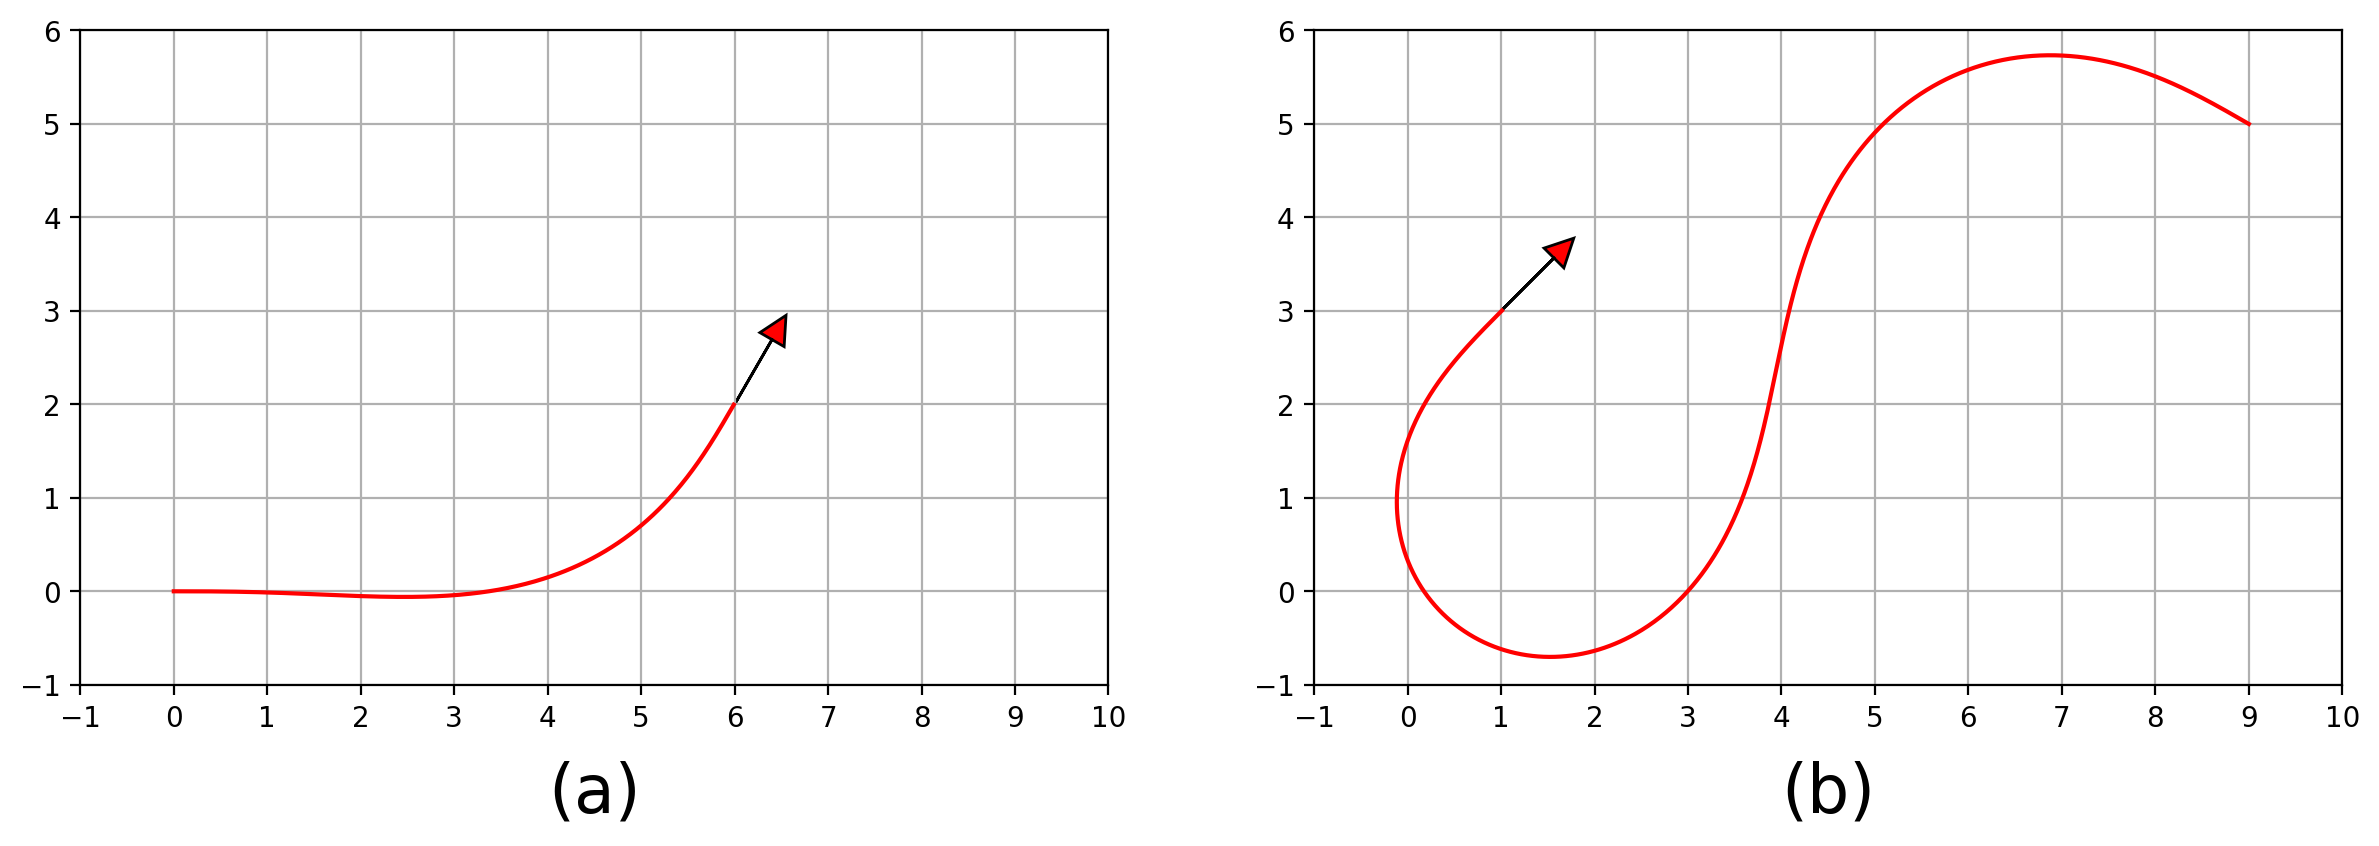

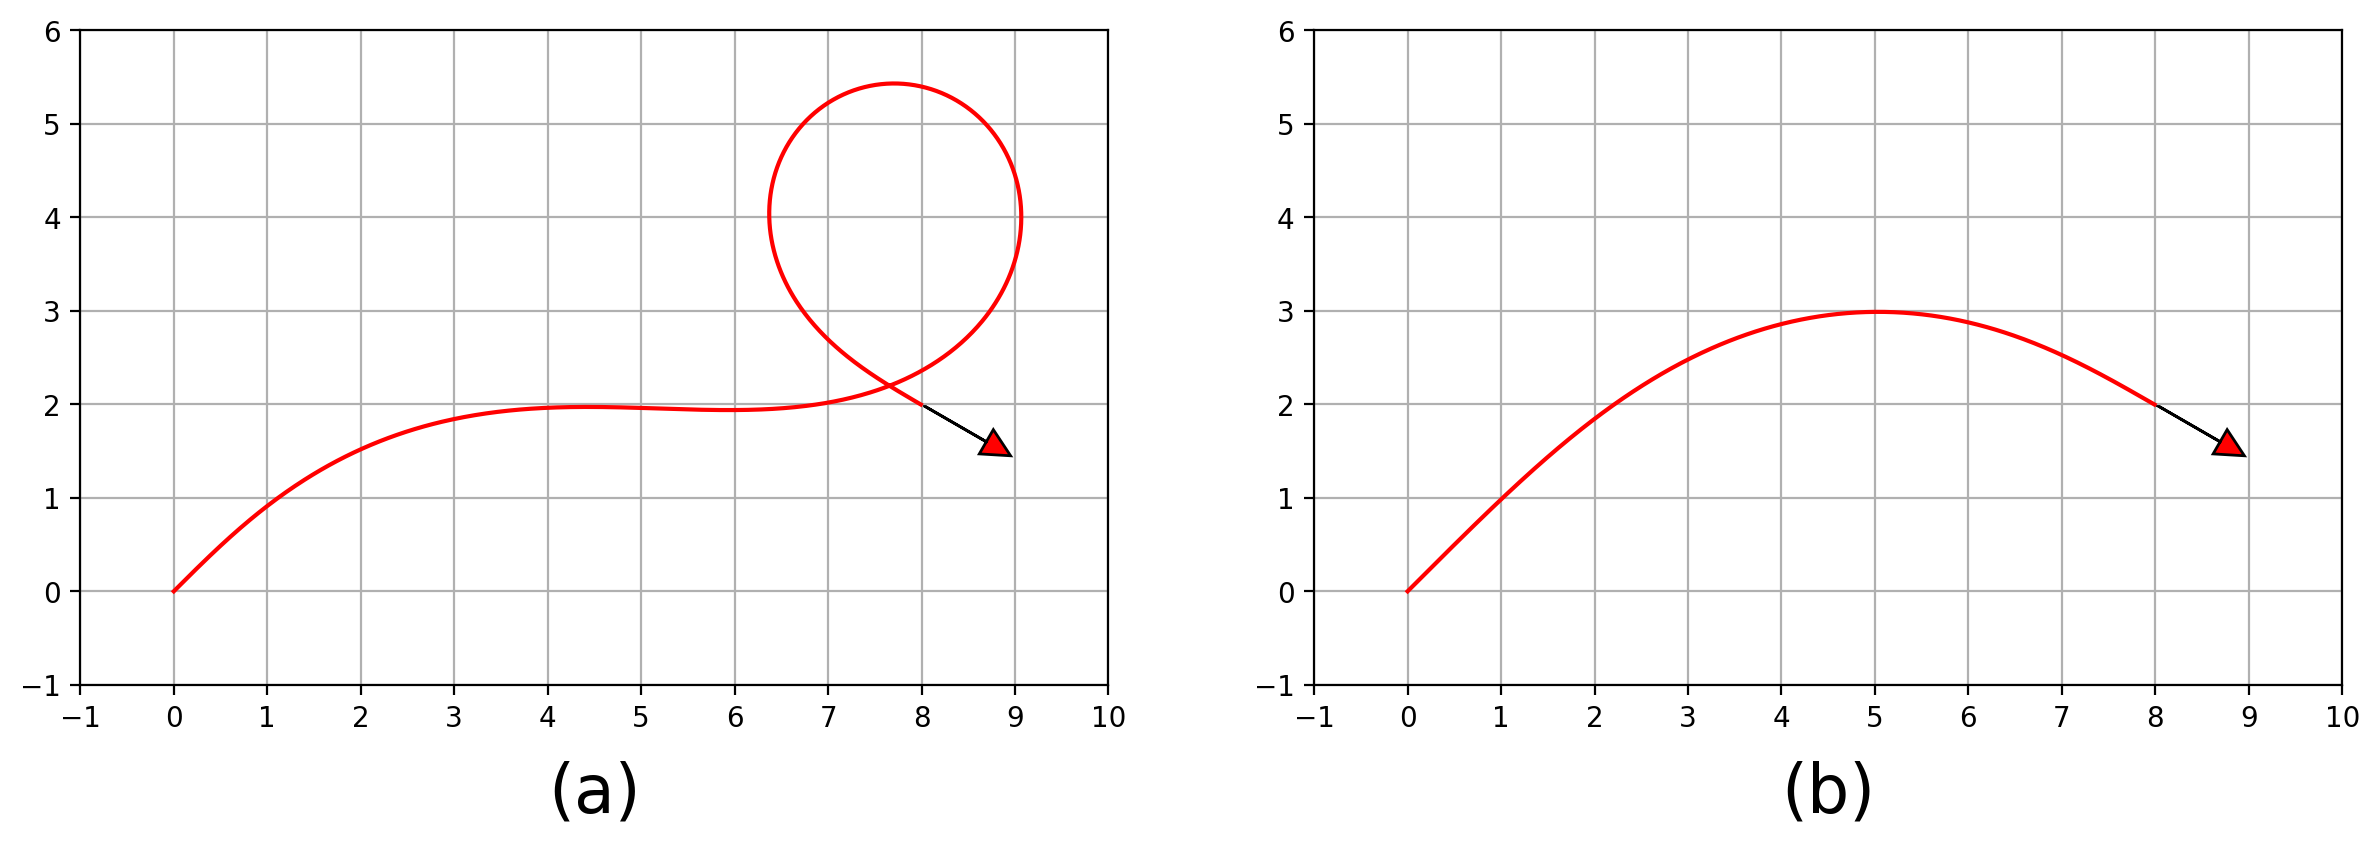

In [7]:
# Список сценариев (пары старта и финиша для траектории) для иллюстрации в статье:
scenarios = [
    (State(0, 0, 0), State(6, 2, np.pi/3)),
    (State(9, 5, 5*np.pi/6), State(1, 3, np.pi/4)),
    (State(0, 0, np.pi/4), State(x=8.0, y=2.0, theta=11*np.pi/6)),
    (State(0, 0, np.pi/4), State(x=8.0, y=2.0, theta=-np.pi/6)),
]

show_trajectories_pairs(scenarios)

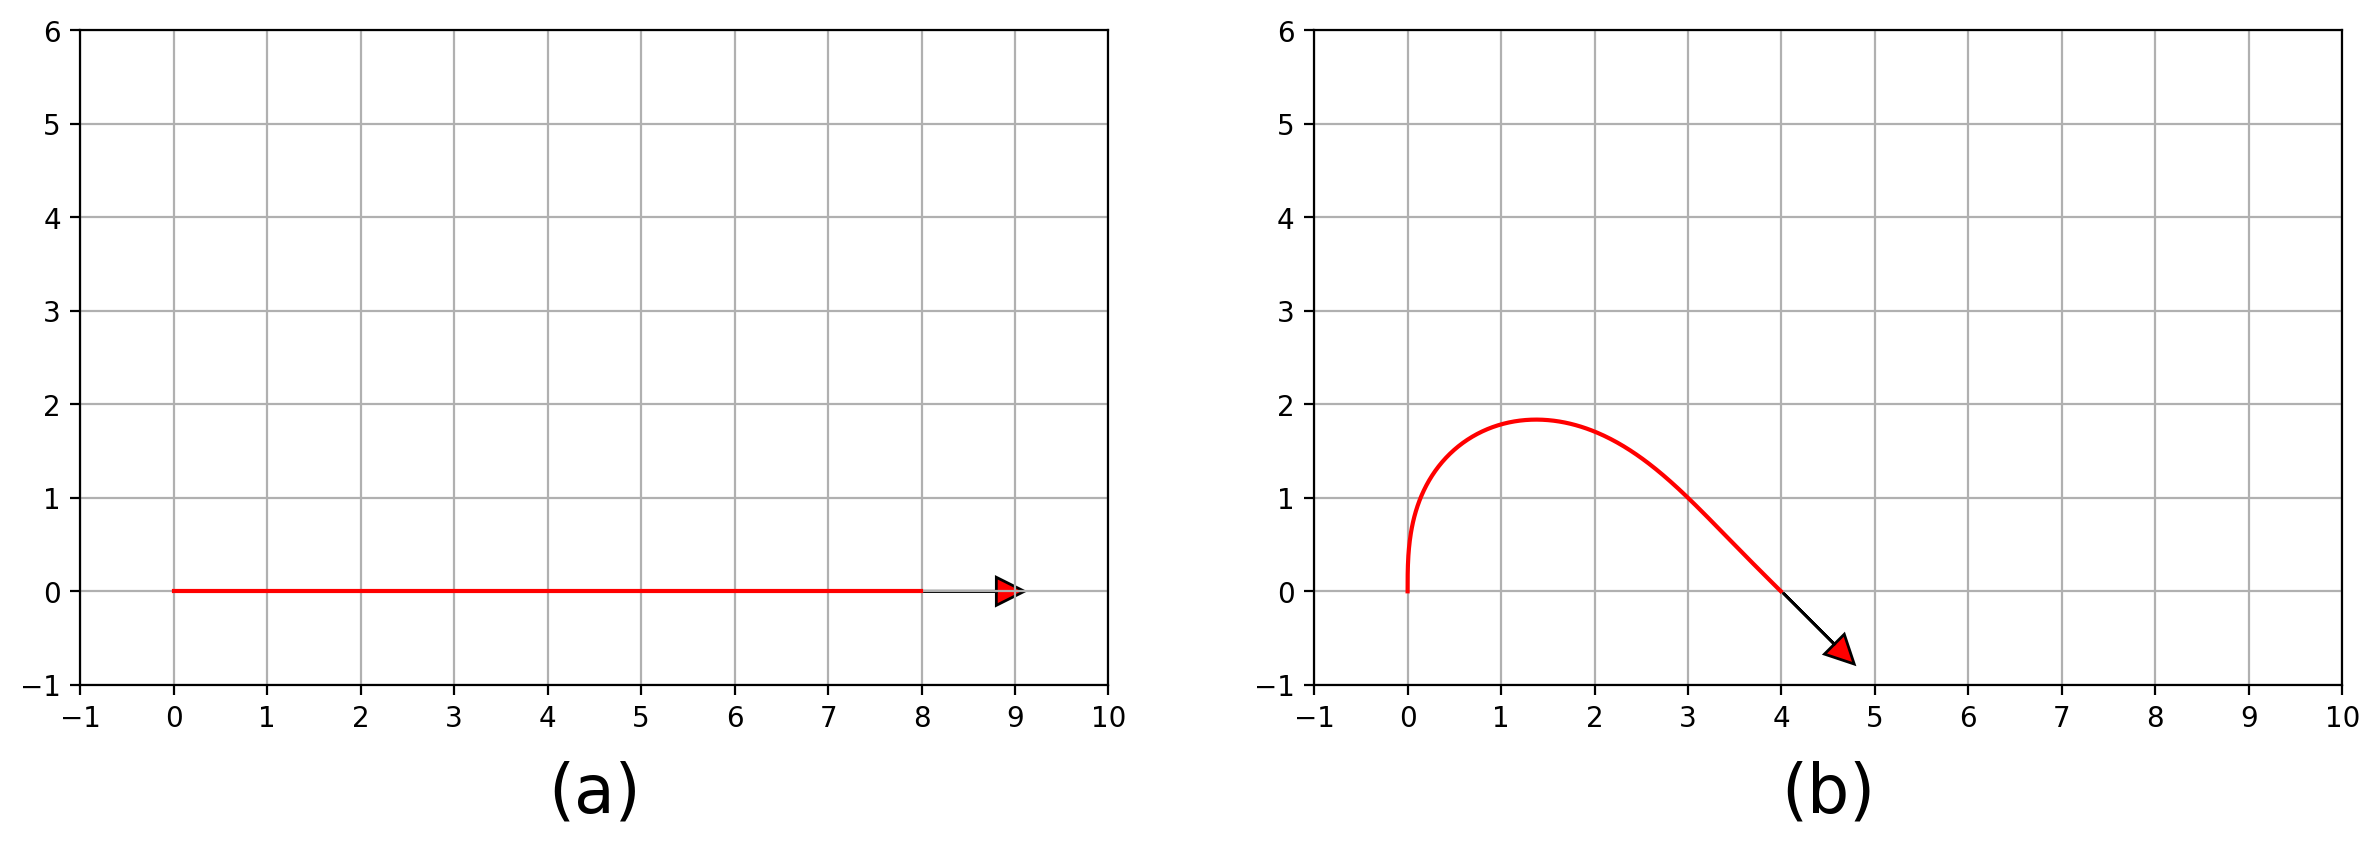

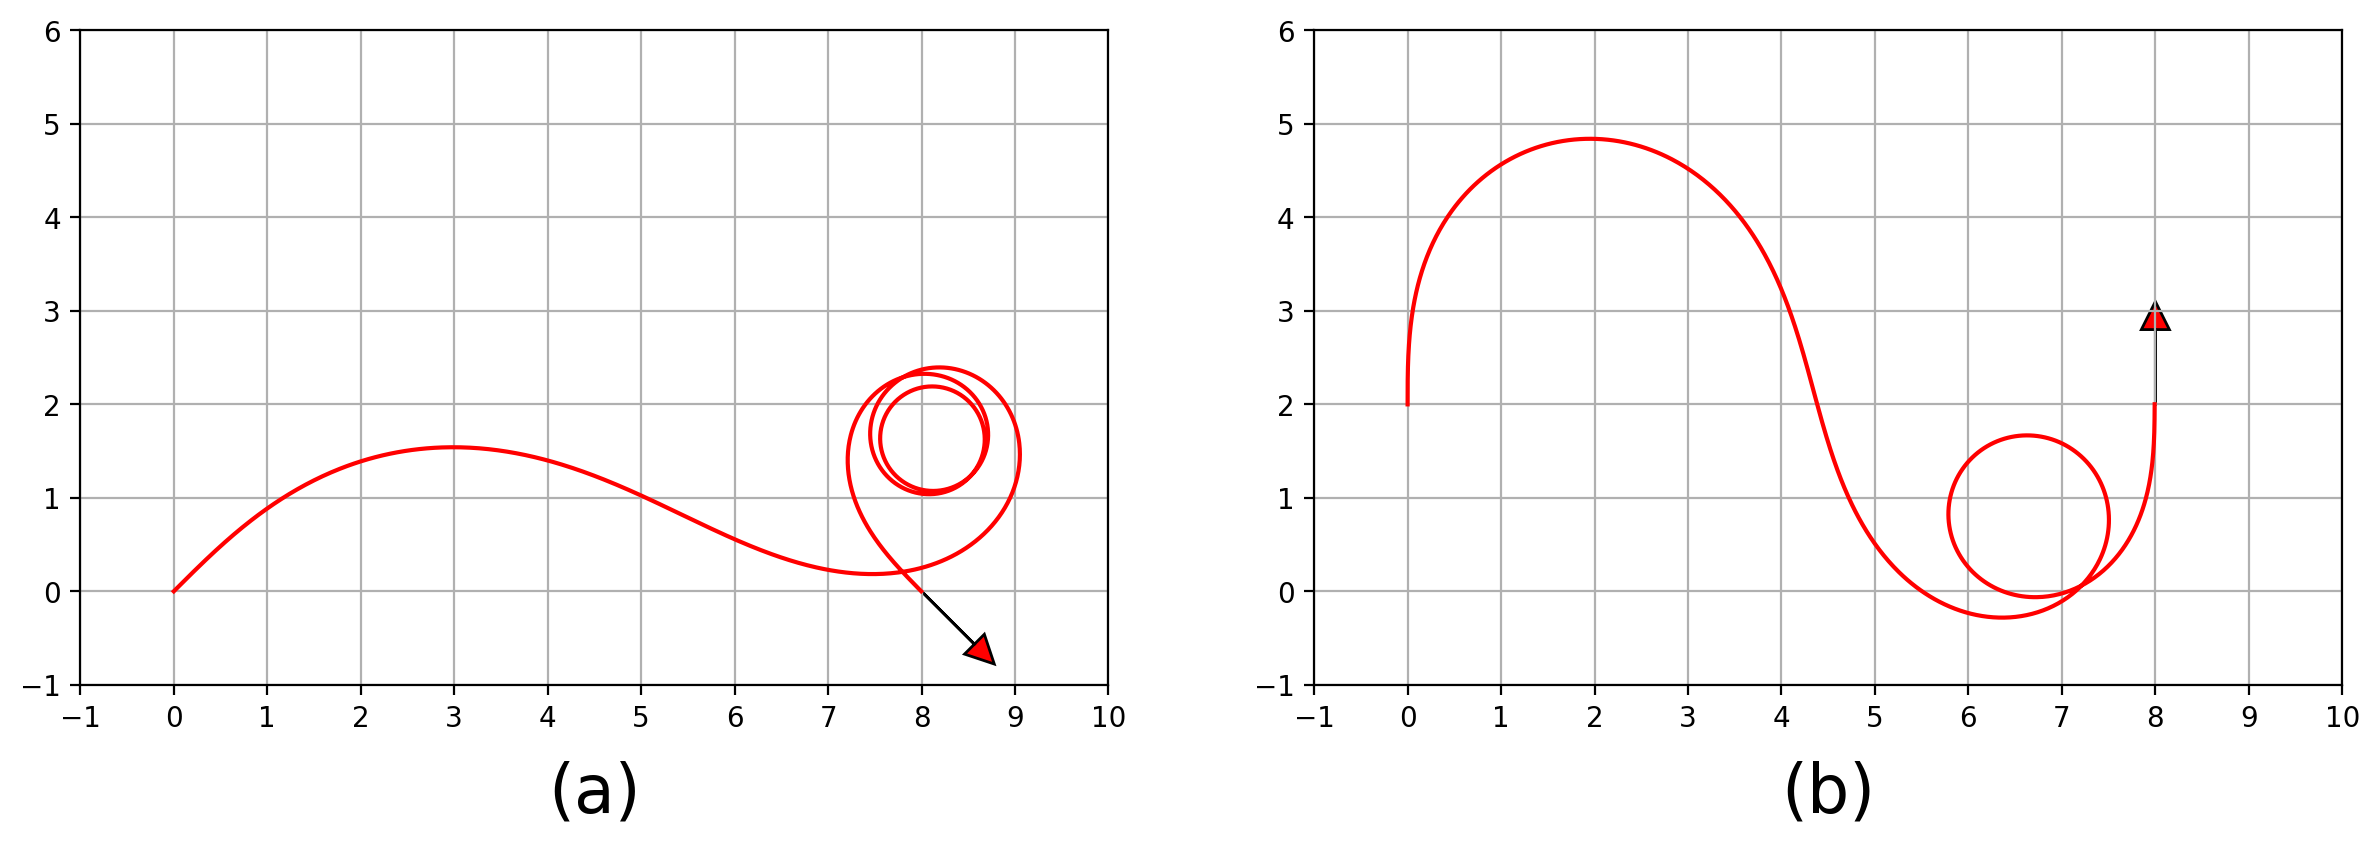

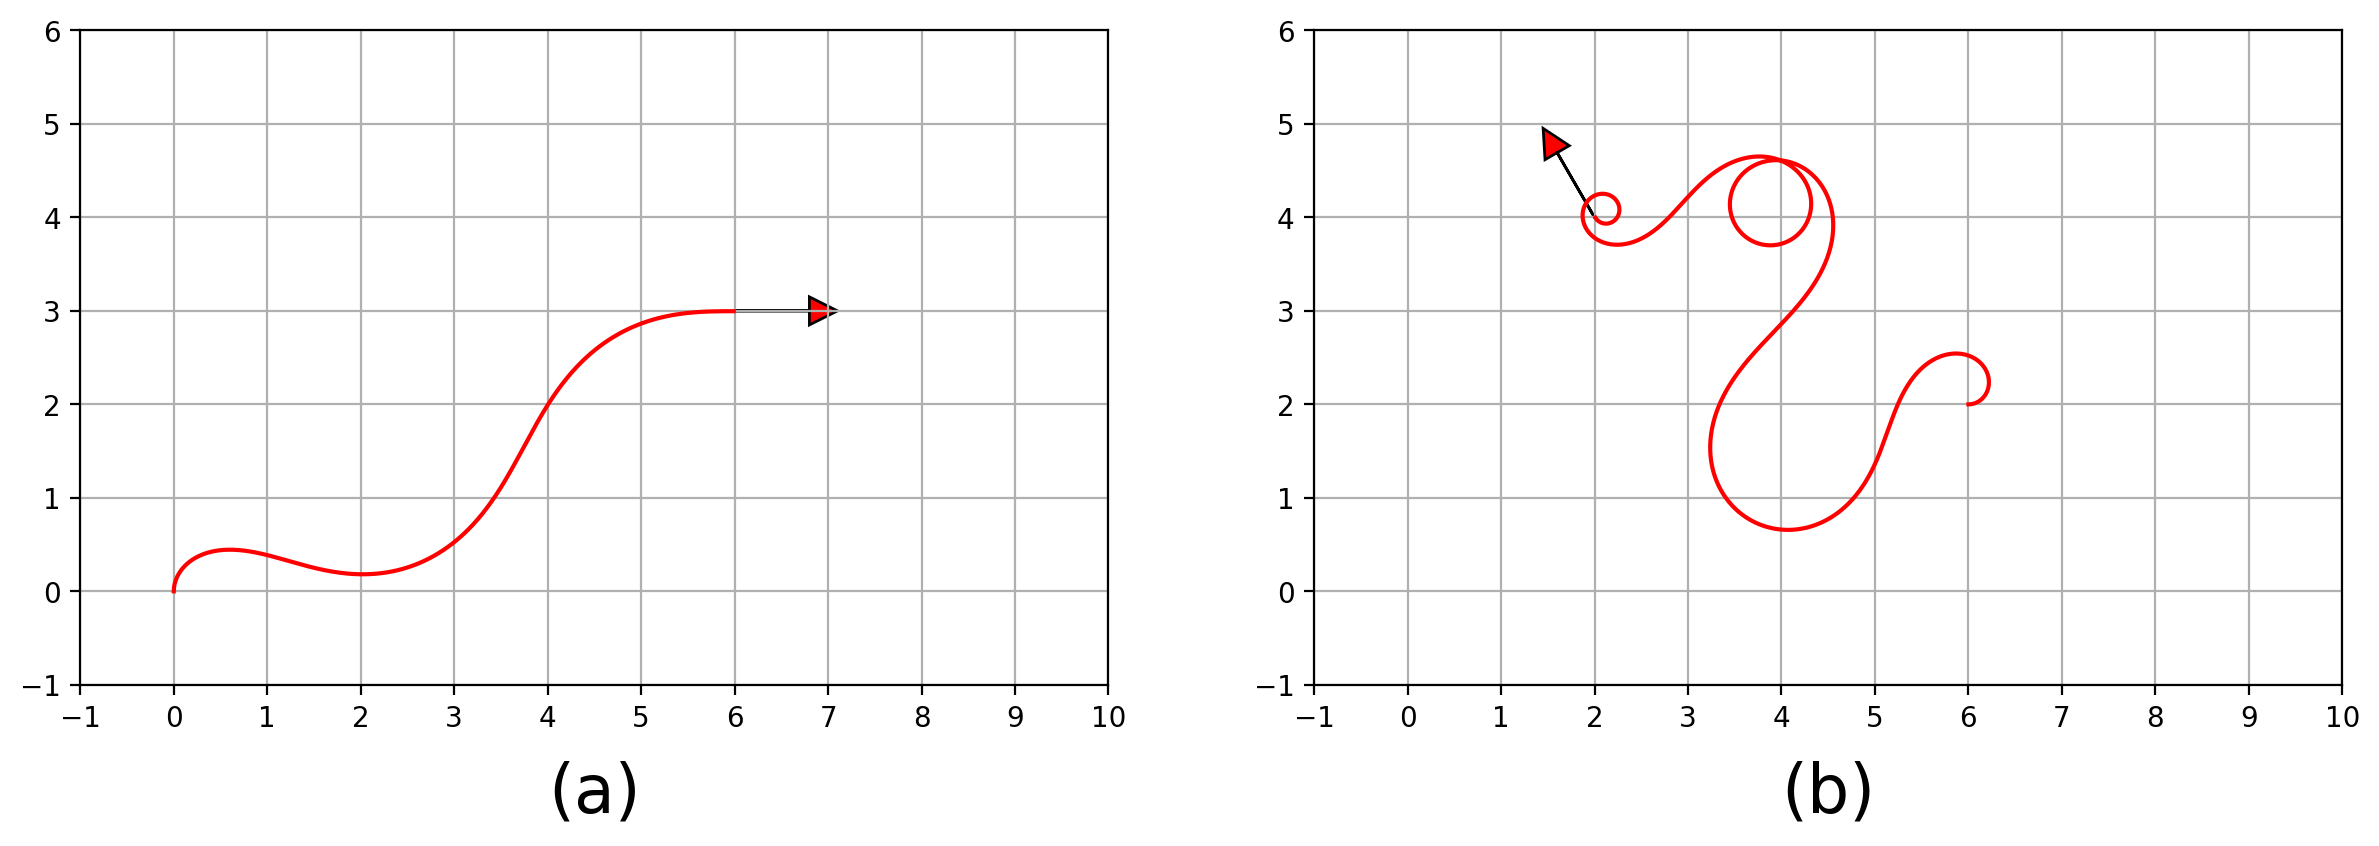

In [8]:
scens = [
    (State(0, 0, 0), State(8, 0, 0)),              # пара простеньких траекторий
    (State(0, 0, np.pi/2), State(4, 0, -np.pi/4)),
                                     
    (State(0, 0, np.pi/4), State(8, 0, -np.pi/4 + 6*np.pi)),  # 2 траектории, где начальный/конечный углы отличаются больше, чем на 2pi ->
    (State(0, 2, np.pi/2), State(8, 2, 2*np.pi+np.pi/2)),     # -> необходимо накрутить петли (= |start.theta - goal.theta| / (2pi) оборотов)

    (State(0, 0, np.pi/2, -3), State(6, 3, 0)),      # траектории, где начальная и конечная кривизна ненулевые
    (State(6, 2, 0, 5), State(2, 4, 2*np.pi/3, -8))
]
show_trajectories_pairs(scens)

интересно, что на последней траектории значения кривизны настолько экстремальные, что траектория начинает закручиваться и даже делает оборот посередине. Но так как начальные и конечные углы у неё отличаются менее, чем на 360 градусов, то оборота быть не должно... поэтому перед финишом она делает ещё один оборот, но уже в другую сторону. Итого: количество оборотов с учётом ориентации получается, как и ожидалось, нулевым.

# Управляющий набор (Control Set)

Ранее мы продемонстрировали, что разработанный метод способен генерировать короткие траектории (примитивы движения) высокой сложности.

Однако на практике часто сложные траектории составляются из более простых примитивов посредством конкатенации. В этом случае обычно имеется заранее сгенерированный конечный **управляющий набор** (*control set*) примитивов движения, которые инкапсулируют кинематические возможности мобильного агента (робота). Это означает, что мобильный агент может выполнять только манёвры, представленные в этом наборе, а задача планирования сложной итоговой траектории таким образом сводится к поиску последовательности примитивов из этого набора.

Примитивы в таком наборе обычно инварианты относительно симметрий и поворотов (так как зачастую от изменения ориентации возможности мобильного агента не меняются).

В данном разделе проиллюстрируем типичный вид такого управляющего набора, сгенерировав примитивы разработанным методом.

In [9]:
def sym_primitives_show(prim: ShortTrajectory, ax=None):
    """
    Функция для рисования симметричных примитивов: будет нарисовано 4 примитива (исходный и 3 его копии поворотом на pi/2 радиан)
    разными цветами: красный, зелёный, синий, желтый.
    """
    
    x, y, theta, k = prim.goal.x, prim.goal.y, prim.goal.theta, prim.goal.k  # сохраняем финальное состояние, куда идёт примитив
    current_prim = copy.deepcopy(prim)  # копируем текущий примитив, чтобы его не портить и работать вместо этого с копией current_prim
    
    # save_primitive(file, current_prim)           # могли бы тут, например, сохранить примитив в файл
    show_trajectory(current_prim, col="r", ax=ax)  # рисуем исходный примитив красным
        
    # центральной симметрией по кругу (по +pi/2 радиан) рисуем остальные три версии примитивы
    current_prim.start.theta += np.pi/2
    current_prim.goal = State(-y, x, theta+np.pi/2, k)
    # save_primitive(file, current_prim)
    show_trajectory(current_prim, col="g", ax=ax)
        
    current_prim.start.theta += np.pi/2                    # поворачиваем примитив на +pi/2 (заметим, что для поворота достаточно обновить стартовый угол и целевое состояние, так как
    current_prim.goal = State(-x, -y, theta+2*np.pi/2, k)  # параметры примитива не поменяются: кривизна и длина не меняются от поворота -> после изменения угла и цели
    # save_primitive(file, current_prim)                   # функции sample_x и sample_y будут давать точки уже повёрнутого примитива)
    show_trajectory(current_prim, col="b", ax=ax)
        
    current_prim.start.theta += np.pi/2
    current_prim.goal = State(y, -x, theta+3*np.pi/2, k)
    # save_primitive(file, current_prim)
    show_trajectory(current_prim, col="y", ax=ax)

Обычно предполагается, что пространство возожных углов ориентаций робота тоже дискретизировано, а примитивы управляющего набора ведут из одного дискертного угла в другой.

В данном примере для дискретизации пространства ориентаций выбрано 16 углов. Помимо стандартных направлений ($0, \pi/4, \pi/2 \dots$), в набор включены углы вида $\arctan(1/2)$ и $\arctan(2)$. Это сделано для того, чтобы робот мог совершать переходы типа «ход конём» (сдвиг на 1 клетку по одной оси и на 2 по другой), попадая точно в целочисленные узлы сетки.

In [10]:
theta_16 = np.array([
        0.0,
        np.arctan(0.5),
        np.pi / 4,
        np.arctan(2.0),
        np.pi / 2,
        np.arctan(0.5) + np.pi / 2,
        3 * np.pi / 4,
        np.arctan(2.0) + np.pi / 2,
        np.pi,
        np.arctan(0.5) - np.pi,
        -3 * np.pi / 4,
        np.arctan(2.0) - np.pi,
        -np.pi / 2,
        np.arctan(0.5) - np.pi / 2,
        -np.pi / 4,
        np.arctan(2.0) - np.pi / 2
])

### Базисные примитивы: Прямые и диагонали

На первом этапе сформируем основу управляющего набора. Мы решаем краевую задачу (генерируем примитив) только для стартовых углов **$0$ радиан** (движение вдоль осей) и **$\pi/4$ радиан** (диагональное движение).

Благодаря функции симметрии, эти два расчёта автоматически покрывают 8 направлений движения ($0, \pi/4, \pi/2, \dots$).
На графиках ниже исходные сгенерированные примитивы показаны **красным** цветом, а их автоматически полученные копии — зелёным, синим и жёлтым.

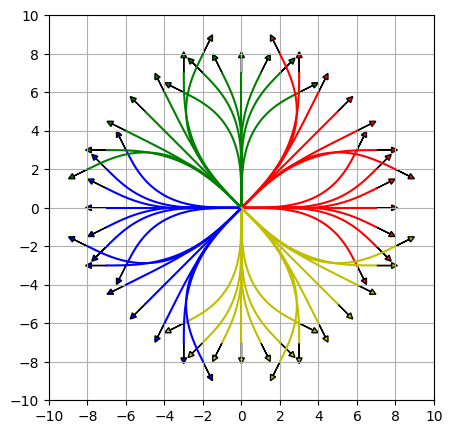

In [11]:
fig = plt.figure(figsize=(5, 5), dpi=100)   # готовим холст для рисования примитивов
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.grid(visible=True, which='both')
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

# Сначала рисуем примитивы, выходящие под углом 0 (а также по три их копии -- для углов pi/2, pi, 3pi/2):
start = State(x=0, y=0, theta=theta_16[0])              # начальное состояние (для угла 0) 
for target in [State(x=7.0, y=0.0, theta=theta_16[0]),  # из start генерируем ровно 7 примитивов в следующие дискретные состояния
               State(x=7.0, y=1.0, theta=theta_16[1]),
               State(x=7.0, y=2.0, theta=theta_16[2]),
               State(x=6.0, y=3.0, theta=theta_16[3]),
               State(x=7.0, y=-1.0, theta=theta_16[-1]),
               State(x=7.0, y=-2.0, theta=theta_16[-2]),
               State(x=6.0, y=-3.0, theta=theta_16[-3])]:
    
    steps, prim = optimization_Newton(start=start, goal=target)  # генерируем очередной примитив
    sym_primitives_show(prim, ax)  # рисуем его, а также ещё три его повёрнутые версии (для углов pi/2, pi, 3pi/2)
                                   # (в итоге всего в цикле сгенерируем 4 * 7 = 28 примитивов, по 7 для четырёх направлений с шагом pi/2)

# Аналогично примитивы для угла 45 градусов (и их копии)
start = State(x=0, y=0, theta=theta_16[2])
for target in [State(x=5.0, y=5.0, theta=theta_16[2]),
               State(x=6.0, y=4.0, theta=theta_16[1]),
               State(x=7.0, y=3.0, theta=0),
               State(x=8.0, y=2.0, theta=theta_16[-1]),
               State(x=4.0, y=6.0, theta=theta_16[3]),
               State(x=3.0, y=7.0, theta=theta_16[4]),
               State(x=2.0, y=8.0, theta=theta_16[5])]:
    
    steps, prim = optimization_Newton(start=start, goal=target)
    sym_primitives_show(prim, ax)

# plt.savefig("control_set_1.png", transparent=False, facecolor='white')
plt.show()

### Расширенные маневры и зеркальная симметрия

Теперь дополнительно добавим примитивы для оставшихся восьми углов ориентации (вида $\arctan(1/2)$ $\arctan(2)$). Так как все эти углы разбиваются на пары симметричных относительно оси $Y$, то здесь мы применяем приём оптимизации — **зеркальное отражение**. Траектория поворота "налево" является зеркальной копией траектории "направо". Вместо того чтобы заново запускать итеративный процесс поиска, мы берем уже рассчитанный примитив и инвертируем его относительно оси $Y$. При этом:
1.  Координата $X$ меняет знак.
2.  Кривизна траектории меняет знак на противоположный (все коэффициенты полинома кривизны умножаются на $-1$).
3.  Длина траектории остаётся неизменной.

Это позволяет расширить управляющий набор в два раза практически без вычислительных затрат.

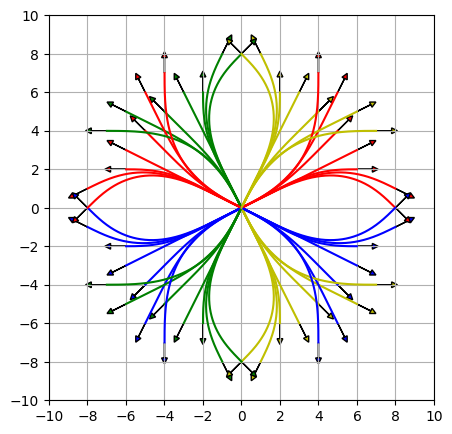

In [12]:
fig = plt.figure(figsize=(5, 5), dpi=100)   # снова готовим холст для рисования примитивов
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.grid(visible=True, which='both')
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

start = State(x=0, y=0, theta=theta_16[1])  # фиксируем дискретное направление = arctan(1/2)
for target in [State(x=6.0, y=3.0, theta=theta_16[1]),          
               State(x=6.0, y=2.0, theta=theta_16[0]),
               State(x=8.0, y=1.0, theta=theta_16[-1]),
               State(x=8.0, y=0.0, theta=theta_16[-2]),
               State(x=5.0, y=4.0, theta=theta_16[2]),
               State(x=5.0, y=6.0, theta=theta_16[3]),
               State(x=4.0, y=7.0, theta=theta_16[4])]:
    
    steps, prim = optimization_Newton(start=start, goal=target)
    sym_primitives_show(prim, ax)
    
    # после отрисовки отражаем примитив относительно оси Y -> тоже рисуем/сохраняем (тоже вместе с копиями с шагом \pi/2):
    prim.start = State(prim.start.x, prim.start.y, theta_16[7], -prim.k0)  # меняем начальный угол и симметрим кривизну
    prim.goal = State(-prim.goal.x, prim.goal.y, theta_16[7] - (prim.goal.theta - theta_16[1]))  # меняем конченое положение (симметрично от Y)
    prim.set_coef_params(-prim.a, -prim.b, -prim.c, prim.length)  # при симметрии примитив поворачивает в другую сторону ->
                                                                  # -> кривизна меняет знак -> все коэффициенты полиномиальной кривизны умножаем на -1 (а длина не меняется)
    sym_primitives_show(prim, ax)

# plt.savefig("control_set_2.png", transparent=False, facecolor='white')
plt.show()